In [115]:
import os
import sys

from urllib.request import Request, urlopen, urlretrieve, HTTPError, URLError
from urllib.parse import quote
from bs4 import BeautifulSoup
from tqdm.auto import tqdm, trange
from typing import List
from pathlib import Path
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sys.path.append('..')
from importlib import reload
from beergenrnn import beerxml, dataset, model

In [29]:
root = 'https://brewdogrecipes.com/recipes/'
page = root + 'p'

In [30]:
skip = ['ab-19', # no info
        'international-arms-race-w-flying-dog', # herbal, no hops
       ]

In [31]:
def get_brewdog_recipe_links(n_pages: int = 14) -> List[str]:
    recipe_links = []
    for i in trange(1, n_pages+1):
        html = urlopen(Request(f"{page}{i}", headers={'User-Agent': 'Mozilla/5.0'}))
        soup = BeautifulSoup(html, "lxml")

        for link in soup.findAll('a'):
            link = link.get('href')
            if link.startswith(root) and not link.startswith(page):
                recipe_links.append(link.replace('/recipes/', '/beerxml/') + '.xml')


    return recipe_links

In [32]:
recipe_links = get_brewdog_recipe_links()

In [117]:
def download_recipes(recipe_links, target_dir: str = '../data', retrieve=False, sleep: float = 0.1):
    target_dir = Path(target_dir)
    target_dir.mkdir(exist_ok=True, parents=True)
    
    for link in tqdm(recipe_links):
        name = link.split('/')[-1]
        path = target_dir / name
        try:
            if retrieve:
                urlretrieve(quote(link, encoding='utf-8', safe=':/'), path)
            else:
                html = urlopen(Request(link, headers={'User-Agent': 'Mozilla/5.0'}))
                with open(target_dir / html.headers.get_filename(), 'wb') as f:
                    f.write(html.read())
        except KeyboardInterrupt:
            break
        except URLError as e:
            continue
        time.sleep(sleep)
        

In [57]:
download_recipes(recipe_links, target_dir='../data/brewdog', retrieve=True)

In [62]:
recipes = list(Path('../data/brewdog/').glob('*.xml'))
len(recipes)

242

In [63]:
recipes[0]

WindowsPath('../data/brewdog/10-heads-high.xml')

In [164]:
def tag_to_dict_list(root, tag):
    tags = []
    try:
        for tag in root.findall(tag)[0]:
            elem_dict = {child.tag.lower(): child.text for child in tag}
            if 'yield' in elem_dict:
                elem_dict['result'] = elem_dict.pop('yield')
            tags.append(elem_dict)
    except:
        print(tag)
    return tags

In [165]:
def read_recipe(path):
    tree = ET.parse(path)
    root = tree.getroot()
    
    style = beerxml.Style(name=root[0].findall('STYLE')[0][0].text,
                          category=root[0].findall('STYLE')[0][1].text)
    
    kwargs = {'fermentables': [beerxml.Fermentable(**t) for t in tag_to_dict_list(root[0], 'FERMENTABLES')],
              'hops': [beerxml.Hop(**t) for t in tag_to_dict_list(root[0], 'HOPS')],
              'yeasts': [beerxml.Yeast(**t) for t in tag_to_dict_list(root[0], 'YEASTS')]
             }
    beer = beerxml.Recipe(style=style, **kwargs)
    return beer

In [150]:
from pprint import pprint

In [170]:
reload(beerxml)

<module 'modules.beerxml' from '..\\modules\\beerxml.py'>

In [171]:
recipes = [read_recipe(r) for r in recipes]

In [173]:
recipes[0]

Recipe(style=Style(name='Red Ale', category='Red Ale'), fermentables=[Fermentable(name='Extra Pale', version='1', type='Grain', amount=4.75, result='82.00', color='2'), Fermentable(name='Caramalt', version='1', type='Grain', amount=1.25, result='71.00', color='15'), Fermentable(name='Crystal 150', version='1', type='Grain', amount=0.5, result='72.00', color='150'), Fermentable(name='Dark Crystal', version='1', type='Grain', amount=0.13, result='72.00', color='80')], hops=[Hop(name='Chinook', version='1', origin=None, alpha=12.6, amount=0.02, use='Boil', time=60, type='Bittering', form='Pellet', beta='0.00'), Hop(name='Chinook', version='1', origin=None, alpha=12.6, amount=0.005, use='Boil', time=30, type='Bittering', form='Pellet', beta='0.00'), Hop(name='Centennial', version='1', origin=None, alpha=9.5, amount=0.005, use='Boil', time=30, type='Aroma', form='Pellet', beta='0.00'), Hop(name='Chinook', version='1', origin=None, alpha=12.6, amount=0.0625, use='Boil', time=0, type='Bitteri

In [176]:
hops = [h.name for r in recipes for h in r.hops]

In [212]:
ferm = [f.name for r in recipes for f in r.fermentables]

In [218]:
yeasts = [f.name for r in recipes for f in r.yeasts]

In [222]:
def count_df(ingr_list):
    df = pd.DataFrame(ingr_list, columns=['name'])
    df['count'] = 1
    df = df.groupby('name').count().reset_index()
    df = df.sort_values('count', ascending=False)
    return df

In [223]:
hops_df = count_df(hops)
ferm_df = count_df(ferm)
yeast_df = count_df(yeasts)

C:\Users\papkov\Anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\papkov\Anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\papkov\Anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\papkov\Anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


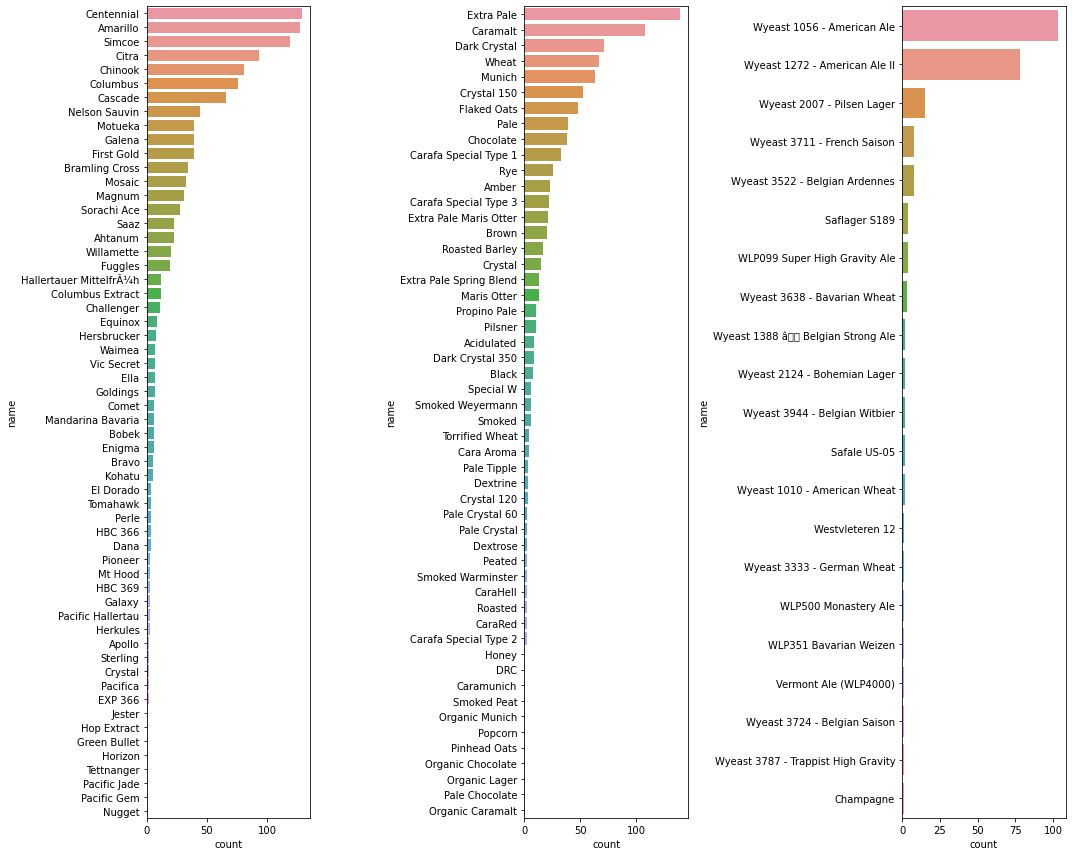

In [221]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 12))
sns.barplot(data=hops_df, x='count', y='name', ax=ax[0])
sns.barplot(data=ferm_df, x='count', y='name', ax=ax[1])
sns.barplot(data=yeast_df, x='count', y='name', ax=ax[2])
plt.tight_layout()
plt.show()

# Brewer's Friend

In [85]:
import time

In [113]:
def get_brewersfriend_recipe_links_page(page: int, root: str = 'https://www.brewersfriend.com/homebrew-recipes', 
                                   recipe_root: str = 'https://www.brewersfriend.com/homebrew/recipe', sort='views-desc'):
    recipe_links = []

    page = f"{root}/page/{page}?sort={sort}"
    request = Request(page, headers={'User-Agent': 'Mozilla/5.0'})
    html = urlopen(request)

    soup = BeautifulSoup(html, "lxml")

    for link in soup.findAll('a'):
        link = link.get('href')
        if link is not None and link.startswith('/homebrew/recipe/view/'):
            recipe_links.append(f'{recipe_root}/beerxml1.0/{link.split("/")[4]}')
            
    return recipe_links

def get_brewersfriend_recipe_links(root: str = 'https://www.brewersfriend.com/homebrew-recipes', 
                                   recipe_root: str = 'https://www.brewersfriend.com/homebrew/recipe',
                                   start_page: int = 1, n_pages: int = 2000, sleep: float = 1, sort='views-desc'):
    recipe_links = []
    n_pages = min(n_pages, 9947)
    
    for page in trange(start_page, n_pages+1):
        time.sleep(1)
        try:
            recipe_links.extend(get_brewersfriend_recipe_links_page(page=page, root=root, recipe_root=recipe_root))
        except HTTPError as e:
            return i, recipe_links

    return page, recipe_links

In [107]:
current_page, brewersfriend_recipe_links = get_brewersfriend_recipe_links(n_pages=5000)

In [110]:
download_recipes(brewersfriend_recipe_links[126:], target_dir='../data/brewersfriend', retrieve=False, sleep=0.5)

In [ ]:
current_page = 1714
n_pages = 5000
recipe_links = []
while current_page < n_pages: 
    print(f'{current_page}', end='\r')
    try:
        brewersfriend_recipe_links = get_brewersfriend_recipe_links_page(page=current_page)
        download_recipes(brewersfriend_recipe_links, target_dir='../data/brewersfriend', retrieve=False, sleep=0.3)
        current_page += 1
    except HTTPError as e:
        time.sleep(60)
        continue